A simple convolutional variational autoencoder.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist, mnist
from tensorflow.keras.models import Model
from scipy.ndimage import gaussian_filter
import time
from IPython import display

(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

(mn_x_train, _), (mn_x_test, _) = mnist.load_data()
mn_x_train = mn_x_train.astype('float32') / 255.
mn_x_test = mn_x_test.astype('float32') / 255.

mn_x_train = mn_x_train[..., tf.newaxis]
mn_x_test = mn_x_test[..., tf.newaxis]

print(x_train.shape)

2023-09-25 17:23:02.502235: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-25 17:23:02.550347: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-25 17:23:03.116575: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


(60000, 28, 28, 1)


In [10]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    """
    Compute the log probability of a Gaussian distribution 
    """
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)


class CVAE(tf.keras.Model):
    """Convolutional variational autoencoder."""

    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
                tf.keras.layers.Conv2D(
                    filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Conv2D(
                    filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
                tf.keras.layers.Flatten(),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
                tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
                tf.keras.layers.Conv2DTranspose(
                    filters=64, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                tf.keras.layers.Conv2DTranspose(
                    filters=32, kernel_size=3, strides=2, padding='same',
                    activation='relu'),
                # No activation
                tf.keras.layers.Conv2DTranspose(
                    filters=1, kernel_size=3, strides=1, padding='same'),
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits


class CVAE_trainer():
    def __init__(self, train_images, test_images, latent_dim=10, batch_size=256):
        self.cvae = CVAE(latent_dim)
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        self.latent_dim = latent_dim
        self.num_examples_to_generate = 16
        self.seed = tf.random.normal([self.num_examples_to_generate, self.latent_dim])
        self.batch_size = batch_size
        self.dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(self.batch_size)
        self.test_dataset = (tf.data.Dataset.from_tensor_slices(test_images).shuffle(test_images.shape[0]).batch(self.batch_size))
        self.num_batches = train_images.shape[0] // self.batch_size
    

    def compute_loss(self, x):
        mean, logvar = self.cvae.encode(x)
        z = self.cvae.reparameterize(mean, logvar)
        x_logit = self.cvae.decode(z)
        cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
        logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
        logpz = log_normal_pdf(z, 0., 0.)
        logpz_x = log_normal_pdf(z, mean, logvar)
        return -tf.reduce_mean(logpx_z + logpz - logpz_x)


    def train_step(self, x):
        """Executes one training step and returns the loss.

        This function computes the loss and gradients, and uses the latter to
        update the model's parameters.
        """
        with tf.GradientTape() as tape:
            loss = self.compute_loss(x)
            gradients = tape.gradient(loss, self.cvae.trainable_variables)
            self.optimizer.apply_gradients(zip(gradients, self.cvae.trainable_variables))


    def train(self, epochs):
        self.generate_random_and_save(0)

        for epoch in range(1, epochs + 1):
            start_time = time.time()
            for train_x in self.dataset:
                self.train_step(train_x)
            end_time = time.time()

            loss = tf.keras.metrics.Mean()
            for test_x in self.test_dataset:
                loss(self.compute_loss(test_x))
            elbo = -loss.result()
            # display.clear_output(wait=False)
            print('Epoch: {}, Test set ELBO: {}, time elapse for current epoch: {}'
                .format(epoch, elbo, end_time - start_time))
            self.generate_random_and_save(epoch)


    def generate_random_and_save(self, epoch):
        z = tf.random.normal(shape=(16, self.latent_dim))
        predictions = self.cvae.sample(z)
        fig = plt.figure(figsize=(4, 4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i + 1)
            plt.imshow(predictions[i, :, :, 0], cmap='gray')
            plt.axis('off')

        # tight_layout minimizes the overlap between 2 sub-plots
        plt.savefig('rand_image_at_epoch_{:04d}.png'.format(epoch))
        plt.show()

         

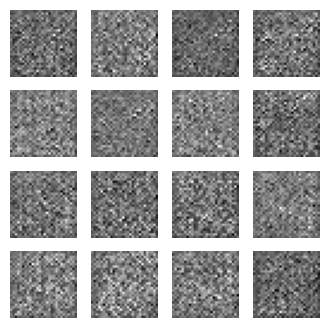

2023-09-25 17:29:22.962355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-09-25 17:29:22.962599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [60000,28,28,1]
	 [[{{node Placeholder/_0}}]]
2023-09-25 17:29:23.604392: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x38fadc60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 17:29:23.604433: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): 

2023-09-25 17:29:24.248052: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-09-25 17:29:24.355311: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-09-25 17:29:24.462728: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-09-25 17:29:24.565505: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

Epoch: 1, Test set ELBO: -227.12258911132812, time elapse for current epoch: 7.691226005554199


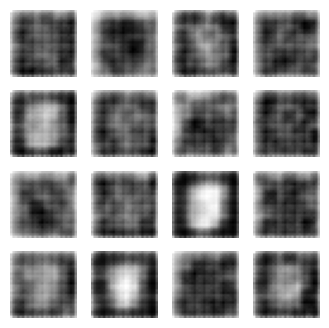

Epoch: 2, Test set ELBO: -202.20697021484375, time elapse for current epoch: 5.360732316970825


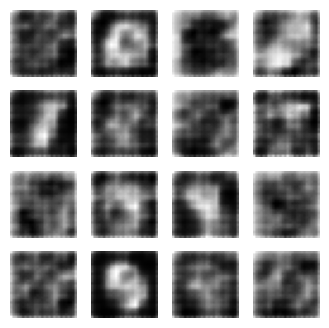

Epoch: 3, Test set ELBO: -179.83399963378906, time elapse for current epoch: 5.23306941986084


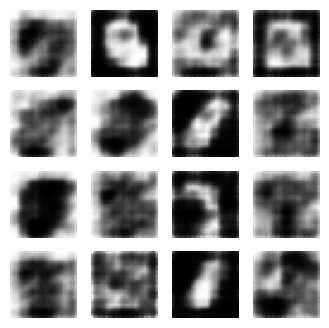

Epoch: 4, Test set ELBO: -157.64549255371094, time elapse for current epoch: 5.27315354347229


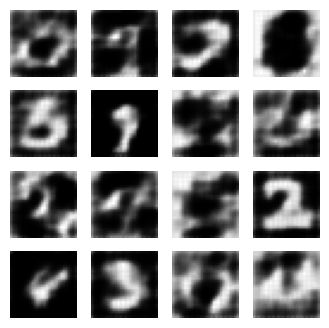

Epoch: 5, Test set ELBO: -138.03224182128906, time elapse for current epoch: 5.264362096786499


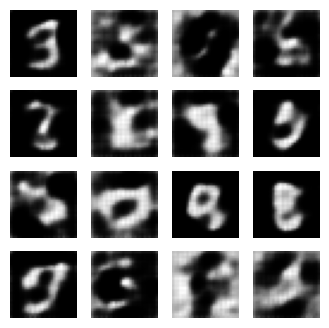

Epoch: 6, Test set ELBO: -131.11187744140625, time elapse for current epoch: 5.286538600921631


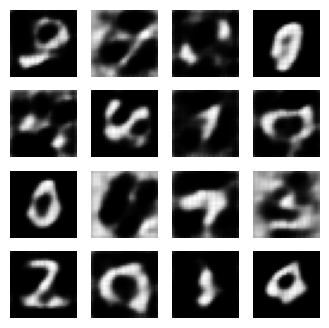

Epoch: 7, Test set ELBO: -127.42445373535156, time elapse for current epoch: 5.269841909408569


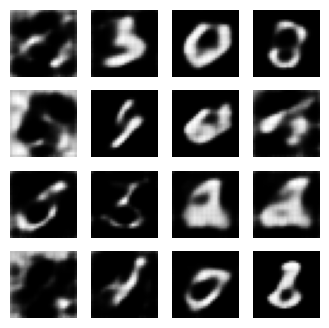

Epoch: 8, Test set ELBO: -124.57603454589844, time elapse for current epoch: 5.28493070602417


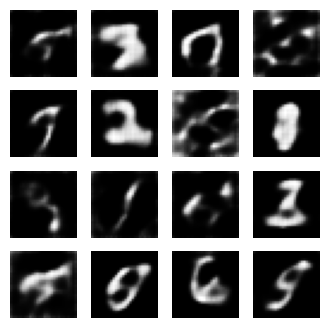

Epoch: 9, Test set ELBO: -122.33744812011719, time elapse for current epoch: 5.263053894042969


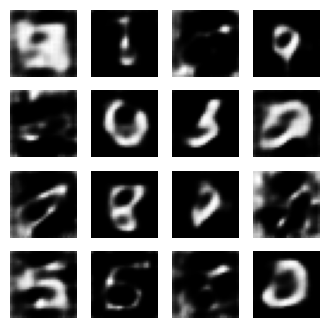

Epoch: 10, Test set ELBO: -120.84217834472656, time elapse for current epoch: 5.266545534133911


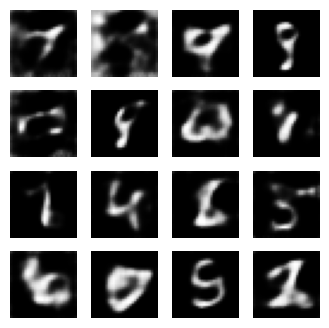

Epoch: 11, Test set ELBO: -119.8561019897461, time elapse for current epoch: 75.27988004684448


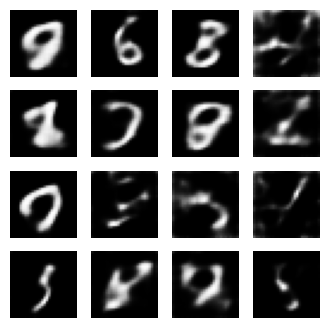

Epoch: 12, Test set ELBO: -118.3058853149414, time elapse for current epoch: 107.67482209205627


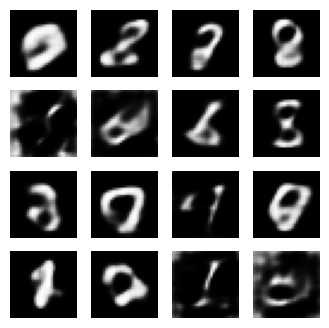

Epoch: 13, Test set ELBO: -117.4104995727539, time elapse for current epoch: 104.64328050613403


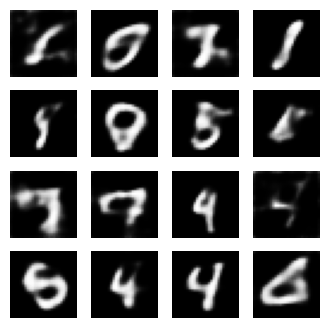

Epoch: 14, Test set ELBO: -116.6022720336914, time elapse for current epoch: 107.98010206222534


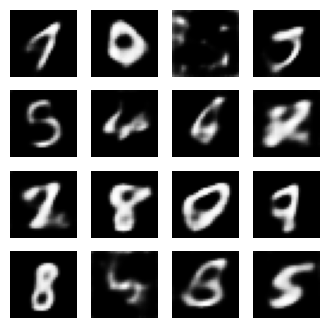

KeyboardInterrupt: 

In [11]:
cvae = CVAE_trainer(mn_x_train, mn_x_test)
cvae.train(epochs=50)